In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

Set seeds

In [2]:
import random

seed_value = 52
torch.manual_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)


## Prepare Data 


Additionally, visualize the data

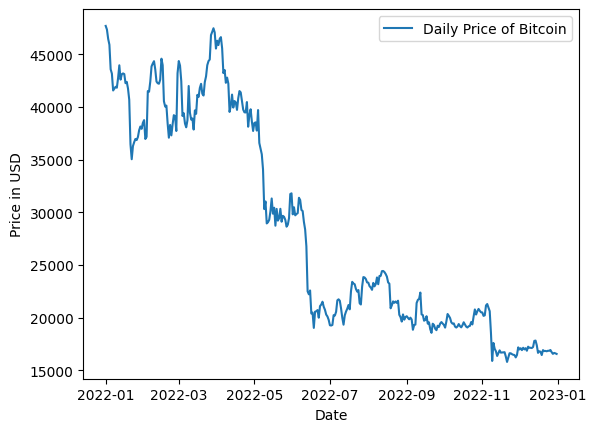

In [3]:
#Load in data
df = pd.read_csv(r"C:\Users\Owner\Documents\Predicting-Bitcoin-Returns-with-Long-Short-Term-Memory-LSTM-Neural-Networks\BTC-USD.csv")

prices = df["Close"].values

dates = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')
ts = pd.Series(prices, index=dates)

plt.plot(ts)
plt.legend(['Daily Price of Bitcoin'])
plt.xlabel("Date")
plt.ylabel("Price in USD")
plt.show()

### Create log returns of bitcoin price

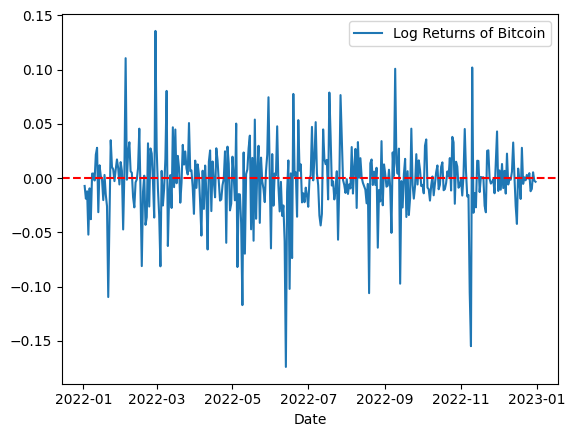

In [4]:
#Log price
log_P = np.log(prices)

#1st difference of ts to remove trend and seasonality
diff = np.diff(log_P)
diff = diff.astype('float32')


#Plot the modified data
dates_4_diff = pd.date_range(start='2022-01-02', end='2022-12-31', freq='D')
timeseries_indexed = pd.Series(diff, index=dates_4_diff)

plt.plot(timeseries_indexed)
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(["Log Returns of Bitcoin"])
plt.xlabel("Date")
plt.show()

Check dimensions of data and change dimensions if needed

In [5]:
print(diff.shape)

diff.resize((364,1)) 

print(f"New size: {diff.shape}")

(364,)
New size: (364, 1)


### Use ADF Test to check for stationarity


In [6]:
from statsmodels.tsa.stattools import adfuller

unit_test = adfuller(diff)

#Print results
print('ADF Statistic: %f' % unit_test[0])
print('p-value: %f' % unit_test[1])
print('Critical Values:', unit_test[4])

if unit_test[1] <= 0.05:
    print(f'Reject the null hypothesis. The time-series is stationary.')
else: 
    print(f"Fail to reject the null hypothesis. The time-series is non-stationary")


ADF Statistic: -19.230854
p-value: 0.000000
Critical Values: {'1%': -3.448493650810824, '5%': -2.8695352280356556, '10%': -2.5710293341377715}
Reject the null hypothesis. The time-series is stationary.


### Train-Validation-Test Split

In [7]:
# train-test split for time series
train_size = int(len(diff) * 0.60)
train, rest = diff[:train_size], diff[train_size:]
validation_size = int(len(rest) * 0.50)
validation, test = rest[:validation_size], rest[validation_size:]

print(len(train))
print(len(validation))
print(len(test))

218
73
73


### Create tensor dataset

In [8]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        inputs = dataset[i:i+lookback]
        labels = dataset[i+lookback:i+lookback+1]
        X.append(inputs)
        y.append(labels)
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))

lookback = 12
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
X_valid, y_valid = create_dataset(validation, lookback=lookback)

## LSTM Class


In [9]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=1, num_layers=1, batch_first=True)
        self.linear = nn.Linear(1, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])
        return x
    def regularization(self, lambda_):
        reg_term = torch.tensor(0.0)
        for param in self.parameters():
            reg_term += torch.sum(param**2)
        return lambda_ * reg_term

## Training


In [16]:
model = LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=1)
lambda_value = 0.0000001
n_epochs = 100



for epoch in range(n_epochs+1):
    model.train()
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        y_pred = y_pred.unsqueeze(2)

        #Loss and Regularization THIS IS WHERE THINGS MESS UP
        loss = loss_fn(y_pred, y_batch)
        reg_term = model.regularization(lambda_value)
        loss = torch.sqrt(loss + reg_term)

        loss.backward()
        optimizer.step()
    # #Progress Printer
    if epoch % 10 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        y_pred = y_pred.unsqueeze(2)
        train_rmse = torch.sqrt(loss_fn(y_pred, y_train) + reg_term)
        
        y_pred = model(X_valid)
        y_pred = y_pred.unsqueeze(2)
        valid_rmse = torch.sqrt(loss_fn(y_pred, y_valid) + reg_term)
    print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, validation RMSE {valid_rmse:.4f}")

Epoch 0: train RMSE 0.0372, validation RMSE 0.0275
Epoch 10: train RMSE 0.0370, validation RMSE 0.0271
Epoch 20: train RMSE 0.0370, validation RMSE 0.0270
Epoch 30: train RMSE 0.0370, validation RMSE 0.0269
Epoch 40: train RMSE 0.0370, validation RMSE 0.0268
Epoch 50: train RMSE 0.0370, validation RMSE 0.0267
Epoch 60: train RMSE 0.0369, validation RMSE 0.0266
Epoch 70: train RMSE 0.0369, validation RMSE 0.0266
Epoch 80: train RMSE 0.0369, validation RMSE 0.0266
Epoch 90: train RMSE 0.0369, validation RMSE 0.0266
Epoch 100: train RMSE 0.0369, validation RMSE 0.0266


Use this to select the optimal value of lambda 

In [11]:
# def reg_selection(dictionary):
#     """
#     Selects the optimal model based on RMSE

#     Input: Dictionary of lambda values and their corresponding RMSE scores
#     Output: Optimal value of Lambda

#     """

#     rmse = None
#     reg_term = None

#     for key, value in dictionary.items():
#         if rmse is None:
#             rmse = value
#             reg_term = key
#         elif value < rmse:
#                 rmse = value
#                 reg_term = key

#     return reg_term      


# print(f"Select {reg_selection(model_select):.10f} as lambda")

## Plotting Results of LSTM



Lookback: 12, train RMSE 0.0369, validation RMSE 0.0266


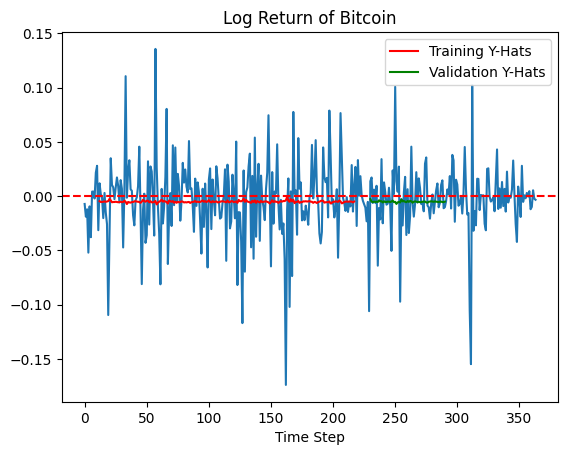

In [17]:
with torch.no_grad():
    ##Shift train predictions for plotting
    train_plot = np.ones_like(diff) * np.nan
    #get predictions for training set
    y_hat_train = model(X_train)
    #RMSE for training set
    rmse_train = torch.sqrt(loss_fn(y_hat_train.unsqueeze(2), y_train))
    #Plot the training predictions
    train_plot[lookback:train_size] = y_hat_train


    #Shift validation predictions for plotting
    valid_plot = np.ones_like(diff) * np.nan
    #Get predictions for testing set
    y_hat_valid = model(X_valid)
    #RMSE for testing set
    rmse_valid = torch.sqrt(loss_fn(y_hat_valid.unsqueeze(2), y_valid))
    #Plot the testing predictions
    valid_plot[train_size+lookback:train_size+len(y_valid)+lookback] = y_hat_valid

print(f"Lookback: {lookback}, train RMSE {rmse_train:.4f}, validation RMSE {rmse_valid:.4f}")


# plot
plt.plot(diff)
plt.plot(train_plot, c='r', label="Training Y-Hats")
plt.plot(valid_plot, c='g', label='Validation Y-Hats')
plt.xlabel('Time Step')
plt.title('Log Return of Bitcoin')
plt.legend()
plt.axhline(y=0, color='r', linestyle='--')
# plt.savefig("365 forecast")
plt.show()

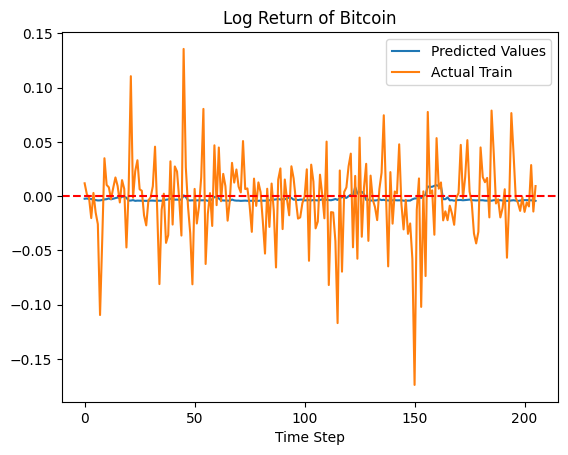

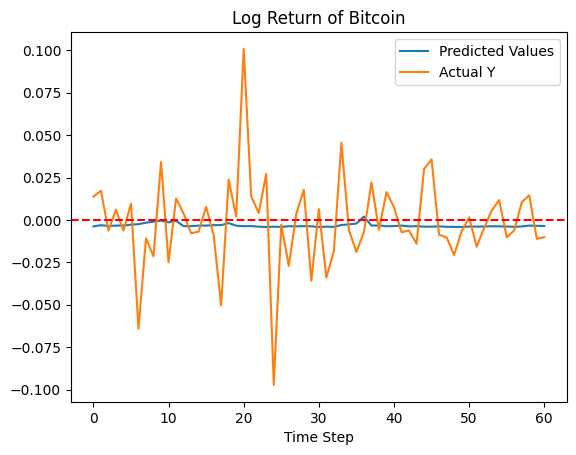

In [13]:
plt.plot(y_hat_train, label="Predicted Values")
plt.plot(y_train.squeeze(), label="Actual Train")
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Time Step')
plt.title('Log Return of Bitcoin')
plt.legend()
# plt.savefig("Trained.png")
plt.show()


plt.plot(y_hat_valid, label="Predicted Values")
plt.plot(y_valid.squeeze(), label="Actual Y")
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Time Step')
plt.title('Log Return of Bitcoin')
plt.legend()
# plt.savefig("Test.png")
plt.show()